In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from micromlgen import port
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [3]:
def load_data_from_directory(directory):
    data = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            data.append(df)
            labels.append(directory)  # Zakładamy, że nazwa folderu to etykieta
    return data, labels

In [45]:
#lewo_data, lewo_labels = load_data_from_directory('lewo')
#przod_data, przod_labels = load_data_from_directory('przod')
avada_data, avada_labels = load_data_from_directory('avada3')
lumos_data, lumos_labels = load_data_from_directory('lumos')
alohomora_data, alohomora_labels = load_data_from_directory('alohomora')
wingardium_data, wingardium_labels = load_data_from_directory('wingardium')

In [5]:
def brief_plot(data):
    rows = len(data) // 4
    fig, ax = plt.subplots(rows,3,figsize=(16,12))
    for i in range(rows):
        for j in range(3):
            ax[i,j].plot(data[3*i+j]["time"], data[3*i+j].iloc[:,1:])

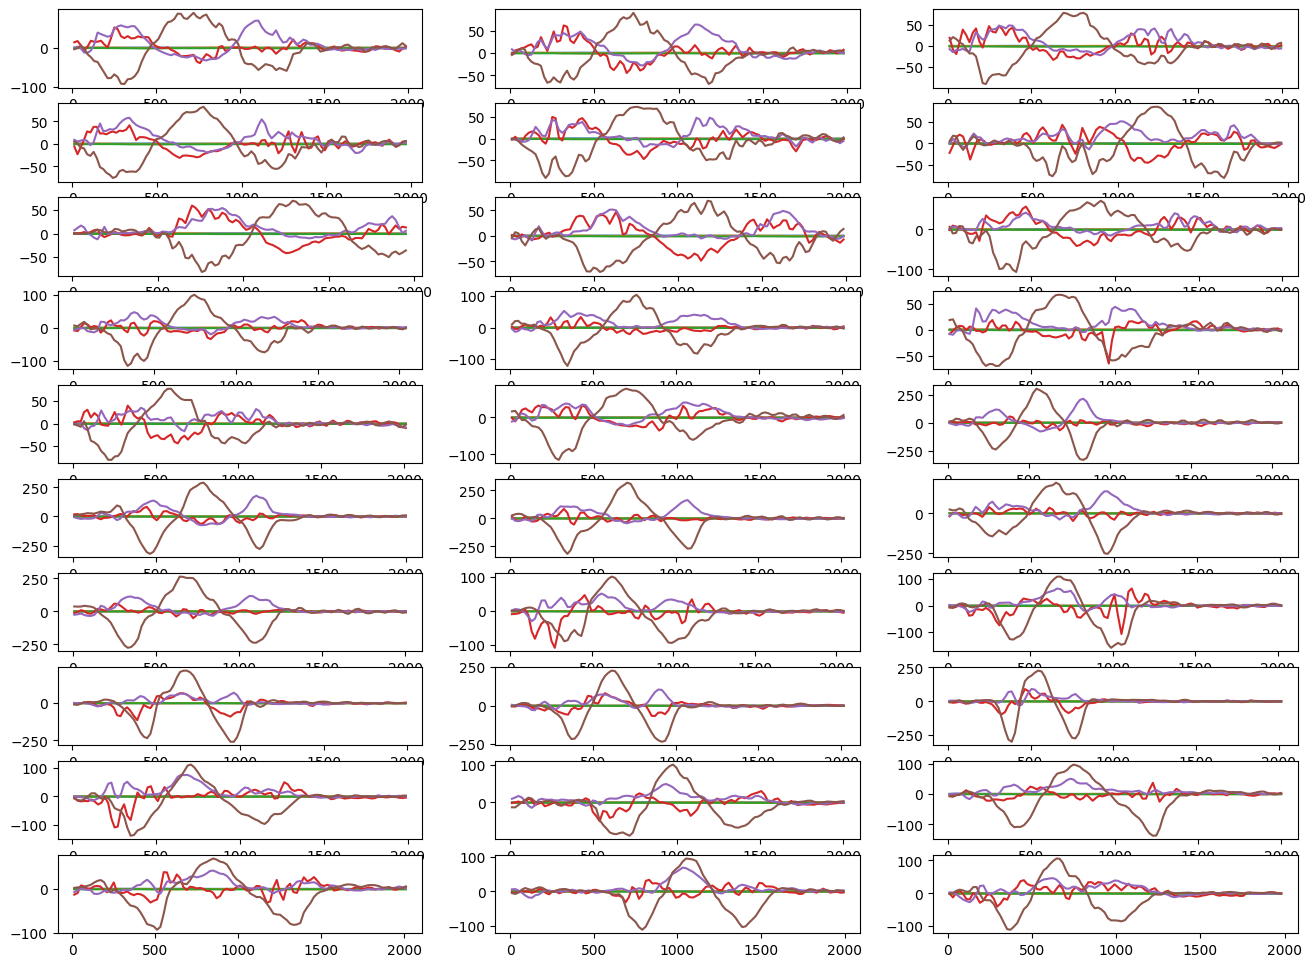

In [46]:
brief_plot(avada_data)

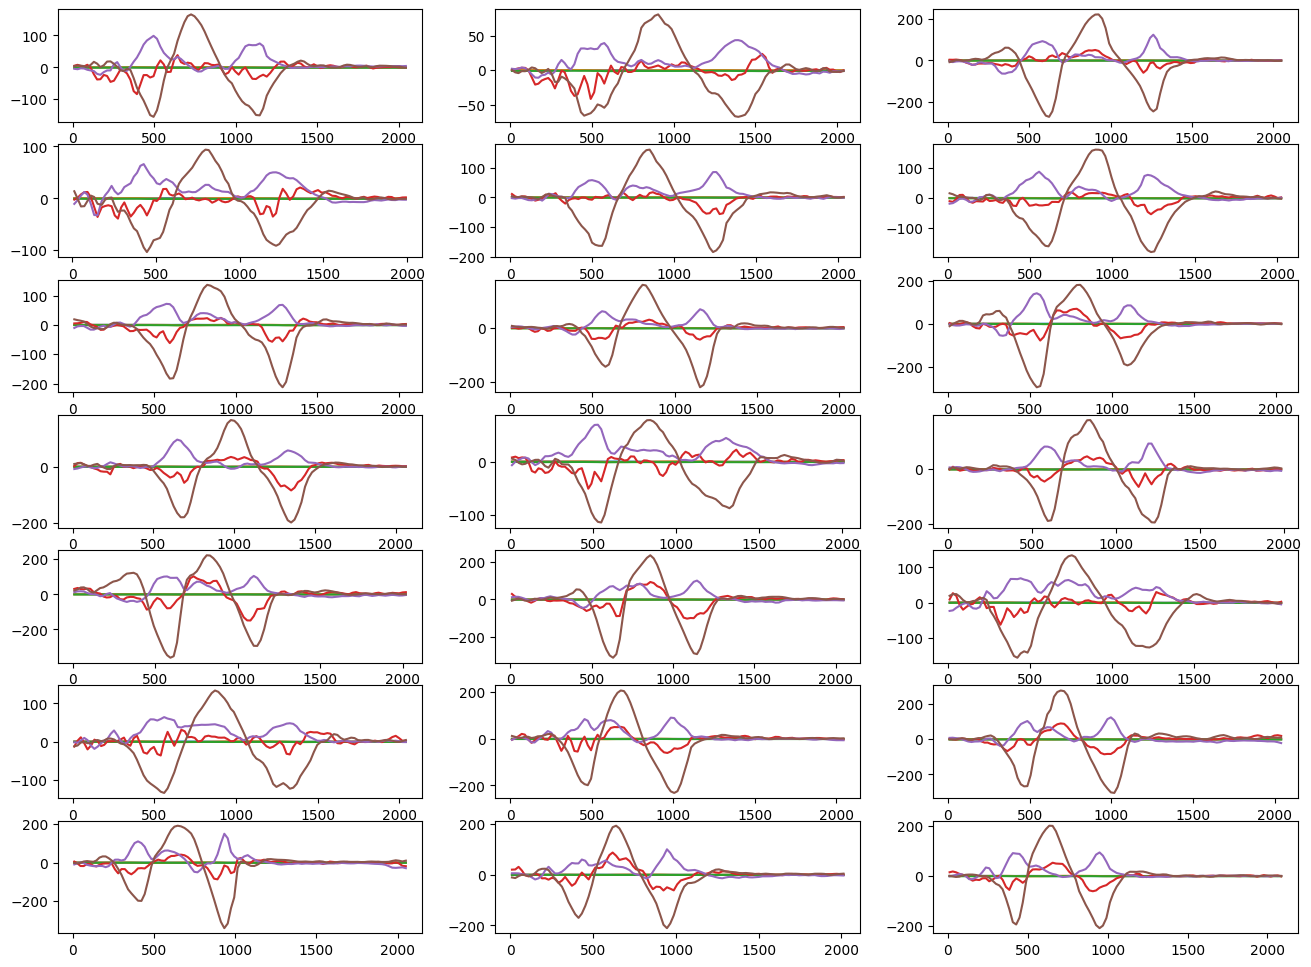

In [30]:
brief_plot(avada_data)

In [47]:
X = avada_data + lumos_data + alohomora_data + wingardium_data # + lewo_data + przod_data
y = avada_labels + lumos_labels + alohomora_labels + wingardium_labels # + lewo_labels + przod_labels

In [48]:
X = [item.flatten() for item in np.array(X)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
a = [None] + list(range(5, 19, 3))

In [77]:
param_grid= {
    'n_estimators': list(range(10,26,2)),
    'min_samples_split': [2,4,5,8]
            }

In [78]:
model = RandomForestClassifier(random_state=42)
grid_search_cv = GridSearchCV(model, param_grid, cv=3,scoring='accuracy',return_train_score=True)
#model.fit(X_train, y_train)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'min_samples_split': [2, 4, 5, 8],
                         'n_estimators': [10, 12, 14, 16, 18, 20, 22, 24]},
             return_train_score=True, scoring='accuracy')

In [79]:
grid_search_cv.best_params_

{'min_samples_split': 4, 'n_estimators': 18}

In [80]:
grid_search_cv.best_score_

0.9413848631239935

In [81]:
model = grid_search_cv.best_estimator_
unknown_X, unknown_Y = load_data_from_directory('unknown3')
unknown_X = [item.flatten() for item in np.array(unknown_X)]

In [82]:
model.predict(unknown_X)

array(['avada3', 'avada3', 'avada3', 'wingardium', 'avada3', 'avada3',
       'avada3', 'avada3', 'lumos', 'lumos', 'lumos', 'lumos', 'lumos',
       'lumos', 'lumos', 'lumos', 'wingardium', 'wingardium',
       'wingardium', 'wingardium', 'alohomora', 'avada3', 'wingardium',
       'wingardium', 'alohomora', 'alohomora', 'alohomora', 'alohomora',
       'alohomora', 'alohomora', 'alohomora', 'alohomora'], dtype='<U10')

In [83]:

# Prawdopodobieństwa przewidywań
proba = model.predict_proba(unknown_X)
print("Prediction probabilities:")
print(proba)


Prediction probabilities:
[[0.08333333 0.88888889 0.02777778 0.        ]
 [0.10185185 0.53703704 0.08333333 0.27777778]
 [0.05555556 0.61111111 0.         0.33333333]
 [0.25       0.34722222 0.01388889 0.38888889]
 [0.02777778 0.79166667 0.125      0.05555556]
 [0.08333333 0.84722222 0.01388889 0.05555556]
 [0.16666667 0.72222222 0.         0.11111111]
 [0.02777778 0.84722222 0.06944444 0.05555556]
 [0.08888889 0.11111111 0.68888889 0.11111111]
 [0.         0.05555556 0.88888889 0.05555556]
 [0.05555556 0.11111111 0.77777778 0.05555556]
 [0.25925926 0.11111111 0.44907407 0.18055556]
 [0.2        0.         0.68888889 0.11111111]
 [0.2        0.         0.74444444 0.05555556]
 [0.2        0.11111111 0.63333333 0.05555556]
 [0.11111111 0.         0.83333333 0.05555556]
 [0.11111111 0.05555556 0.         0.83333333]
 [0.05555556 0.         0.         0.94444444]
 [0.16666667 0.16666667 0.         0.66666667]
 [0.05555556 0.22222222 0.16666667 0.55555556]
 [0.36111111 0.33333333 0.08333333

In [84]:
class_map = {label: i for i, label in enumerate(set(y))}  # Mapuj unikalne etykiety na indeksy

class_map

class_map = {'alohomora': 0, 'wingardium':3, 'avada':1, 'lumos': 2}

In [85]:
c_code = port(model, classmap={v: k for k, v in class_map.items()})

with open("./arduCode/mainCode/model_with_labels.h", "w") as f:
    f.write(c_code)